In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gp

from copy import copy
from unidecode import unidecode
from functools import reduce
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
from bias_correction import BiasCorrection, XBiasCorrection

relevant_municipalities = ["buenos aires coronel dorrego", "buenos aires hipolito yrigoyen"]

column_names = {
    "X":"lon",
    "Y":"lat",
    "M":"member",
    "L":"lead",
    "S":"init_date",
    "Z":"height",
    "tref":"tmean",
    "prec":"rain"
}

%load_ext autoreload
%autoreload 2

### 1. Read data

**Polygon shapes**

To forecast wheat yield in Argentina, we use weather data from two locations - Buenos Aires Coronel Dorrego and Buenos Aires Hipolito Yrigoyen. In this notebook we read hindcasts from the NMME that is provided in 1° x 1° grid cells. For each location, we need to find the grid cells that are closest. 

In [2]:
# polygon shapes of the two municipalities that are relevant for the forecast model
gdf_adm2 = gp.read_file("data/shapefile/arg_admbnda_adm2_unhcr2017.shp")[["ADM1_ES", "ADM2_ES", "geometry"]]
# concatenate name of state and municipality
gdf_adm2["name"] = gdf_adm2[["ADM1_ES", "ADM2_ES"]].apply(lambda x: unidecode(x[0].lower()) + " " + unidecode(x[1].lower()), axis=1)
# filter the two relevant names
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(["buenos aires coronel dorrego", "buenos aires hipolito yrigoyen"]), ["name", "geometry"]].reset_index(drop=True)
# convert to dictionary for easier access
name_to_shape = gdf_adm2.set_index("name")["geometry"].to_dict()
# preview
name_to_shape

{'buenos aires coronel dorrego': <POLYGON Z ((-61.175 -38.293 0, -61.174 -38.293 0, -61.173 -38.293 0, -61.17...>,
 'buenos aires hipolito yrigoyen': <POLYGON Z ((-61.45 -36.052 0, -61.435 -36.039 0, -61.393 -36.072 0, -61.333...>}

**ERA data**

The ERA5-Land-Reanalysis [Dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=form) is needed to bias-adjustment.

In [3]:
era = pd.read_csv("data/era_filtered_locations.csv").assign(model="ERA", init_month=12)
# the redundant part of the location "Buenoas Aires" can be removed
era["name"] = era["name"].apply(lambda x: x.replace("buenos aires ", ""))
era = era[["model", "year", "init_month", "month", "rain", "tmean", "name"]]
era.columns = ["model", "year", "init_month", "forecasted_month", "rain", "tmean", "location"]
# preview
era.head(2)

,model,year,init_month,forecasted_month,rain,tmean,location
0,ERA,1993,12,8,0.000204,10.112333,coronel dorrego
1,ERA,1994,12,8,0.001294,9.102000,coronel dorrego


**NMME**

The North [American Multi-Model Ensemble](https://www.cpc.ncep.noaa.gov/products/NMME/) consists of six Seasonal climate models whose hindcasts are available [here](http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/). We collected data from four seasonal climate models.

- NCAR/University of Miami CCSM4.0 (**CCSM4**)
- GFDL-SPEAR (**GFDL**)
- NASA Goddard Space Flight Center (GSFC) GEOS5 (**GSFC**)
- NOAA NCEP CFSv2 (**NCEP**)
- NCAR CESM - data for 2011-2015 not available; not considered in this study
- Environment Canada CanCM3 and CanCM4 - collected from Copernicus Climate Data Store; different notebook	


In [4]:
all_models = []
for model in ["NCEP", "NASA", "GFDL", "CCSM4"]:
    path = "data/" + model + "/"
    directory = os.fsencode(path)
    prec_temp_current_model = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        print(filename)
        if filename.endswith("nc"):
            df = xr.open_dataset("{}{}".format(path, filename), engine="netcdf4", decode_times=False).to_dataframe().reset_index()
            ref_date = date(1960, 1, 1)
            df["S"] = df["S"].apply(lambda x: ref_date + relativedelta(months=+x))
            df.columns = [column_names[c] for c in df.columns]
            if "tmean" in df.columns:
                df = df.groupby(["lat", "lon", "init_date", "lead"]).agg({"tmean":"mean"}).reset_index()
                df["tmean"] = df["tmean"].apply(lambda x: x - 273.15) # conversion to degree celsius
            else:
                df = df.groupby(["lat", "lon", "init_date", "lead"]).agg({"rain": lambda x: np.mean(x) / 1000}).reset_index()
            
            df["init_date"] = pd.to_datetime(df["init_date"])
            df["year"] = df["init_date"].dt.year
            df["init_month"] = df["init_date"].dt.month

            df = df.loc[(df["year"].between(1993, 2016)) & (df["init_month"].between(6, 11)) & ((df["init_month"] + df["lead"]).between(6, 12.5))].reset_index(drop=True)
            prec_temp_current_model.append(df)
    
    complete_model = reduce(lambda x, y: pd.merge(x, y, on=["lat", "lon", "init_date", "lead", "year", "init_month"], how="outer"), prec_temp_current_model).assign(model=model)
    if "rain_x" in complete_model.columns:
        complete_model["rain"] = complete_model["rain_x"].fillna(complete_model["rain_y"])
        complete_model = complete_model.drop(columns={"rain_x", "rain_y"})
    if "tmean_x" in complete_model.columns:
        complete_model["tmean"] = complete_model["tmean_x"].fillna(complete_model["tmean_y"])
        complete_model = complete_model.drop(columns={"tmean_x", "tmean_y"})
    
    complete_model = gp.GeoDataFrame(complete_model, geometry=gp.points_from_xy(complete_model["lon"], complete_model["lat"]), crs="EPSG:4326") 
    all_models.append(complete_model)      
          
nmme = pd.concat(all_models, axis=0, ignore_index=False)
nmme.head()

Forecast
Hindcast
NCEP_MONTHLY_PREC_1993_2010.nc
NCEP_MONTHLY_TEMP_1993_2010.nc
NCEP_PENTAD_SAMPLES_PREC_2011_2023.nc
NCEP_PENTAD_SAMPLES_TEMP_2011_2023.nc
NASA-GEOSS2S_PREC.nc
NASA-GEOSS2S_TEMP.nc
GFDL-SPEAR_PREC.nc
GFDL-SPEAR_TEMP.nc
COLA-RSMAS-CCSM4_PREC.nc
COLA-RSMAS-CCSM4_TEMP.nc


,lat,lon,init_date,lead,year,init_month,model,rain,tmean,geometry
0,-40.0,-63.0,1993-06-01,0.5,1993,6,NCEP,0.001164,9.936151,POINT (-63.00000 -40.00000)
1,-40.0,-63.0,1993-06-01,1.5,1993,6,NCEP,0.001036,9.016626,POINT (-63.00000 -40.00000)
2,-40.0,-63.0,1993-06-01,2.5,1993,6,NCEP,0.001008,9.870935,POINT (-63.00000 -40.00000)
3,-40.0,-63.0,1993-06-01,3.5,1993,6,NCEP,0.001248,12.057397,POINT (-63.00000 -40.00000)
4,-40.0,-63.0,1993-06-01,4.5,1993,6,NCEP,0.001551,14.067010,POINT (-63.00000 -40.00000)


<Axes: >

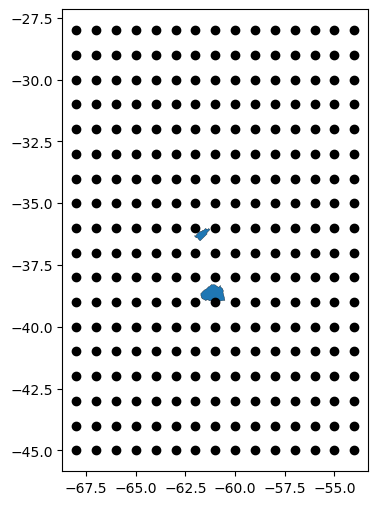

In [5]:
base = gdf_adm2.plot(figsize=(6,6), edgecolor="black", linewidth=.2)
gp.GeoDataFrame(nmme.groupby("geometry").size().reset_index(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black")

### 2. Find closest location to municipalities

In [6]:
modelling_groups = nmme["model"].unique()
li = []
for model in modelling_groups:
    current_model = nmme.loc[nmme["model"] == model, ["model", "lat", "lon", "geometry"]].drop_duplicates()
    location_1 = pd.DataFrame(current_model.iloc[current_model.sindex.nearest(name_to_shape[relevant_municipalities[0]])[1][0]]).transpose().assign(location="coronel dorrego").reset_index(drop=True)
    location_2 = pd.DataFrame(current_model.iloc[current_model.sindex.nearest(name_to_shape[relevant_municipalities[1]])[1][0]]).transpose().assign(location="hipolito yrigoyen").reset_index(drop=True)
    locations = pd.concat([location_1, location_2], ignore_index=True)
    
    current_model = current_model.merge(locations, on=["model", "lat", "lon", "geometry"], how="left").dropna()
    li.append(current_model)
    
model_locations = pd.concat(li, ignore_index=True, axis=0)

<Axes: >

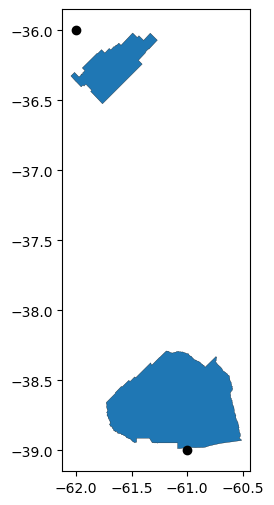

In [7]:
nmme = nmme.merge(model_locations, on=["model", "lat", "lon", "geometry"]).dropna()

base = gdf_adm2.plot(figsize=(6,6), edgecolor="black", linewidth=.2)
gp.GeoDataFrame(nmme.groupby("geometry").size().reset_index(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black")

### 3. Convert lead time to forecasted month

In [8]:
# lead_time_1 = (2 * lead_time_0.5 + lead_time_1.5) / 2 ; lead_time_2 = (lead_time_1.5 + lead_time_2.5) / 2 ; ...
nmme["modified rain"] = nmme[["lead", "rain"]].apply(lambda x: 2*x[1] if x[0] == 0.5 else x[1], axis=1)
nmme["modified rain"] = nmme.sort_values(by=["model", "location", "year", "init_month", "lead"])["modified rain"].rolling(2).mean()
nmme["modified tmean"] = nmme.sort_values(by=["model", "location", "year", "init_month", "lead"])["tmean"].rolling(2).mean()
# window size two of rolling mean means that first entry is irrelevant
nmme = nmme.loc[(nmme["lead"] != 0.5)].reset_index(drop=True)
# rename lead from X.5 to X
nmme["lead"] = nmme.loc[:, "lead"].astype(str).str[:-2].astype(int)

In [9]:
# adjustment of column names
nmme = nmme[["model", "year", "init_month", "lead", "location", "modified rain", "modified tmean"]]
nmme.loc[:, "forecasted_month"] = nmme.loc[:, "init_month"] + nmme.loc[:, "lead"] - 1
nmme = nmme.rename(columns={"modified rain":"rain", "modified tmean":"tmean"})
nmme.head()

,model,year,init_month,lead,location,rain,tmean,forecasted_month
0,NCEP,1993,6,1,coronel dorrego,0.002000,9.823221,6
1,NCEP,1993,6,2,coronel dorrego,0.001506,9.298410,7
2,NCEP,1993,6,3,coronel dorrego,0.001685,10.035181,8
3,NCEP,1993,6,4,coronel dorrego,0.001982,11.528711,9
4,NCEP,1993,6,5,coronel dorrego,0.002352,13.592279,10


### 4. bias adjustment

In [10]:
nmme = nmme[["model", "year", "init_month", "forecasted_month", "rain", "tmean", "location"]]
nmme = nmme.loc[nmme["forecasted_month"].between(8,11)].reset_index(drop=True)
nmme.groupby("model").size()

model
CCSM4    864
GFDL     864
NASA     864
NCEP     864
dtype: int64

In [11]:
def adjust_bias(observed, predicted, correction_method="basic_quantile"):
    """Apply bias-adjustment to daily temperature values of hindcasts.
    
    parameters:
     - observed: observed climate data
     - predicted: hindcast data
     - correction_method: bias-correction method to be applied. Can be 'normal_mapping', 'basic_quantile', 'gamma_mapping', 'modified_quantile'
    
    returns: 
     - results: bias-adjusted hindcasts as dataframe  
    """
    # GroupBy objects allow faster access to relevant subsets of climate data.
    grouped_climate_observations = observed.groupby(["location", "year", "forecasted_month"])
    grouped_climate_hindcasts = predicted.groupby(["model", "init_month", "location", "year", "forecasted_month"])
    grouped_climate_hindcasts_reference = copy(grouped_climate_hindcasts)
    li = []
    
    for group_idx, group_content in grouped_climate_hindcasts:
        # Save group characteristics in intuitive variables.
        current_model = group_content["model"].unique()[0]
        current_init_month = group_content["init_month"].unique()[0]
        current_zone = group_content["location"].unique()[0]
        current_season = group_content["year"].unique()[0]
        current_month = group_content["forecasted_month"].unique()[0]
        
        # Create calibration set of observations and hindcasts.
        hindcasts_used_as_reference = []
        observations_used_as_reference = []
        for season in list(range(1993,2017)): 
            if season != current_season:
                observation_to_be_added = (current_zone, season, current_month) 
                observations_used_as_reference.append(grouped_climate_observations.get_group(observation_to_be_added))   
            hindcast_to_be_added = (current_model, current_init_month, current_zone, season, current_month)
            hindcasts_used_as_reference.append(grouped_climate_hindcasts_reference.get_group(hindcast_to_be_added))
        hindcasts_used_as_reference = pd.concat(hindcasts_used_as_reference, axis=0, ignore_index=False)
        observations_used_as_reference = pd.concat(observations_used_as_reference, axis=0, ignore_index=False) 
        
        # Perform bias-adjustment for temperature variables.
        bc_tmean = BiasCorrection(observations_used_as_reference["tmean"], hindcasts_used_as_reference["tmean"], group_content["tmean"])
        bc_rain = BiasCorrection(observations_used_as_reference["rain"], hindcasts_used_as_reference["rain"], group_content["rain"])
        group_content["tmean"] = bc_tmean.correct(method=correction_method)
        group_content["rain"] = bc_rain.correct(method=correction_method)
        
        li.append(group_content)
    result = pd.concat(li, axis=0, ignore_index=True)       
    
    return result

In [12]:
adjusted_hindcasts = adjust_bias(era, nmme)

### 5. Features structure 

In [13]:
# Bring NMME hindcasts into right structure where features are columns and rows are model-year-init_month
hindcasts_pivot = adjusted_hindcasts.pivot(index=["model", "year", "init_month"], columns=["location", "forecasted_month"], values=["tmean", "rain"]).reset_index()
hindcasts_pivot.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in hindcasts_pivot.columns]
hindcasts_pivot.columns = [c.strip("_") for c in hindcasts_pivot.columns]
hindcasts_pivot = hindcasts_pivot.loc[(hindcasts_pivot["init_month"] >= 9)].reset_index(drop=True)

# Bring ERA into right structure where features are columns and rows are model-year
era_pivot = era.pivot(index=["model", "year", "init_month"], columns=["location", "forecasted_month"], values=["tmean", "rain"]).reset_index()
era_pivot.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in era_pivot.columns]
era_pivot.columns = [c.strip("_") for c in era_pivot.columns]
era_pivot = era_pivot.sort_values(by=["model", "year", "init_month"])

# features for month < init_months are NaNs and will be replaced with era-reanalysis data
all_models = hindcasts_pivot.set_index("year").combine_first(era_pivot.set_index("year")).reset_index()
# concat ERA with init_month = 12  
all_models = pd.concat([all_models, era_pivot], ignore_index=True)
all_models = all_models.drop_duplicates().reset_index(drop=True)
all_models = all_models.loc[all_models["init_month"] >= 9].sort_values(by=["model", "year", "init_month"]).reset_index(drop=True)

# bring columns into right order
all_models = all_models[
    ['model', 'year', 'init_month', 'rain_coronel dorrego_10', 'rain_coronel dorrego_11', 'rain_coronel dorrego_8', 'rain_coronel dorrego_9', 'rain_hipolito yrigoyen_10', 
     'rain_hipolito yrigoyen_11', 'rain_hipolito yrigoyen_8', 'rain_hipolito yrigoyen_9', 'tmean_coronel dorrego_10', 'tmean_coronel dorrego_11', 'tmean_coronel dorrego_8', 
     'tmean_coronel dorrego_9', 'tmean_hipolito yrigoyen_10', 'tmean_hipolito yrigoyen_11', 'tmean_hipolito yrigoyen_8', 'tmean_hipolito yrigoyen_9']
    ]

all_models.head()

,model,year,init_month,rain_coronel dorrego_10,rain_coronel dorrego_11,rain_coronel dorrego_8,rain_coronel dorrego_9,rain_hipolito yrigoyen_10,rain_hipolito yrigoyen_11,rain_hipolito yrigoyen_8,rain_hipolito yrigoyen_9,tmean_coronel dorrego_10,tmean_coronel dorrego_11,tmean_coronel dorrego_8,tmean_coronel dorrego_9,tmean_hipolito yrigoyen_10,tmean_hipolito yrigoyen_11,tmean_hipolito yrigoyen_8,tmean_hipolito yrigoyen_9
0,CCSM4,1993,9,0.001914,0.001682,0.000204,0.000481,0.001813,0.001993,0.000622,0.001456,14.775476,18.665766,10.112333,11.109643,15.590184,19.729484,10.272308,11.739533
1,CCSM4,1993,10,0.001709,0.002920,0.000204,0.000629,0.002610,0.002895,0.000622,0.002687,13.950095,17.116167,10.112333,11.635667,14.812184,17.946175,10.272308,11.610769
2,CCSM4,1993,11,0.001886,0.003932,0.000204,0.000629,0.002157,0.004106,0.000622,0.002687,14.787833,17.735342,10.112333,11.635667,16.042308,18.755298,10.272308,11.610769
3,CCSM4,1994,9,0.002642,0.002067,0.001294,0.001237,0.006214,0.004433,0.002331,0.003539,14.272221,17.325104,9.102000,10.396786,15.011918,17.718173,9.853077,11.481451
4,CCSM4,1994,10,0.003602,0.002061,0.001294,0.000819,0.004558,0.002098,0.002331,0.001586,12.804345,17.709609,9.102000,11.997500,14.406293,18.397051,9.853077,12.882308


### EXPORT

In [15]:
all_models.to_csv("data/features/bias_adjusted_nmme_features.csv", index=False)